### QPSK Implementation

The following quadrature phase shift keying (QPSK) example illustrates the fundamental elements of a digital quadrature communication system. This incorporates streamlined transmitter and receiver components which include bit-to-symbol mapping, upsampling and downsampling of the baseband signal, pulse shaping, and carrier frequency modulation and demodulation. The progression of these modules is summarized in Figure 1, and each will be discussed in the subsequent sections to demonstrate their functionality as well as the capabilities of the accompanying signal processing library.

<div style="text-align: center;">
    <img src="./images/QPSK/qpsk_full_system_diagram.png" alt="" width="1000" />
    <p style="text-align: center;">Figure 1: QPSK System Transmitter and Receiver Architecture</p>
</div>

#### System Configuration

First, the developed signal processing library must be imported as well as plotting and linear algebras libraries to aid in later visualization of the system's internal variables.

In [1]:
from helper_functions import sp_library as sp
import numpy as np
import matplotlib.pyplot as plt

Next, before the transmitter can be described, a set of system parameters must be configured to define the design. QPSK has already been selected as the modulation type, and the remaining system parameters are set below, including the corresponding constellation map, system noise $ N_o $, sample rate $ f_s $, carrier frequency $ f_c $, and the input message.

In [3]:
qpsk_constellation = [[complex( np.sqrt(1) +  np.sqrt(1)*1j), 3], 
                      [complex( np.sqrt(1) + -np.sqrt(1)*1j), 2], 
                      [complex(-np.sqrt(1) + -np.sqrt(1)*1j), 0], 
                      [complex(-np.sqrt(1) +  np.sqrt(1)*1j), 1]]
noise = 2*(10**-4)
fs = 8
fc = .25 * fs
input_message_ascii = "this is a qpsk transceiver test!"

&nbsp;
### Transmitter Architecture

#### Bit to Symbol Mapping

Binary-to-symbol mapping is typically performed using lookup tables (LUT). For this example, the previously defined simple 2-D constellation will suffice as that LUT. The input message, represented by ASCII characters, must first be converted into a binary stream, then segmented into groups of two bits for the QPSK symbol mapping.

In [3]:
# mapping the ascii characters to binary
input_message_bits = ''.join(sp.string_to_ascii_binary(input_message_ascii))

# grouping the binary into blocks of two bits
input_message_blocks = [input_message_bits[i:i+2] for i in range(0, len(input_message_bits), 2)]

# mapping each block to a symbol in the constellation
input_message_symbols = [int(bit2, 2) for bit2 in input_message_blocks]

The symbols representing the input message are then mapped onto the in-phase and quadrature channels using the previously defined constellation. Additionally, a header is appended at this stage, providing the system's modules with a warm-up period before the actual message is processed. This helps to mitigate any irregularities that may occur during system startup.

In [4]:
bits_to_amplitude = {bit: amplitude for amplitude, bit in qpsk_constellation}

# inphase channel symbol mapping
xk = np.real([bits_to_amplitude[symbol] for symbol in input_message_symbols])

# quadrature channel symbol mapping
yk = np.imag([bits_to_amplitude[symbol] for symbol in input_message_symbols])

# adding header to each channel
header = [1, 0] * 50
xk = np.concatenate([header, xk])
yk = np.concatenate([header, yk])

An excerpt from the message signal is plotted below as well as some of the system configuration parameters printed.


Header Length: 100 symbols
Message Length: 212 symbols
Sample Rate: 8 samples per symbol
Carrier Frequency: 2.0 Hz



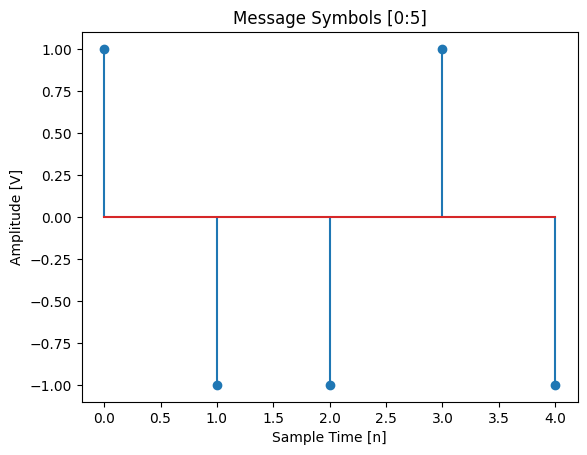

In [5]:
print(f"\nHeader Length: {len(header)} symbols")
print(f"Message Length: {len(xk)} symbols")
print(f"Sample Rate: {fs} samples per symbol")
print(f"Carrier Frequency: {fc} Hz\n")

# plot original symbols
plt.figure()
plt.stem(yk[len(header):len(header)+5])
plt.title("Message Symbols")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplitude [V]")
plt.show()

#### Upsampling

The next step in the transmitter process is upsampling the message symbols using the predefined sample rate \( f_s \). Upsampling increases the signal’s sampling rate, providing finer resolution in symbol representation. This is crucial in digital communication systems, as it enables accurate pulse shaping and modulation, ensuring that the baseband signal is effectively represented. The upsampling process is mathmatically represented below:

$$
x\left(nT_s\right)\:\rightarrow \:x_{upsampled}\left(\frac{nT_s}{N}\right)\:\rightarrow \:\:x\left(nT_N\right)
$$

where: 
- $ N $ is the upsample rate,
- $ T_s $ is the sample duration, 
- $ n $ is the sample index,
- $T_N$ is the upsampled sample duration.

In [6]:
xk_upsampled = sp.upsample(xk, fs)
yk_upsampled = sp.upsample(yk, fs)

An excerpt of the upsampled signal is plotted below, along with a constellation diagram of the in-phase and quadrature components. Since no noise has been introduced into the system, all the constellation points align perfectly with the ideal constellation.

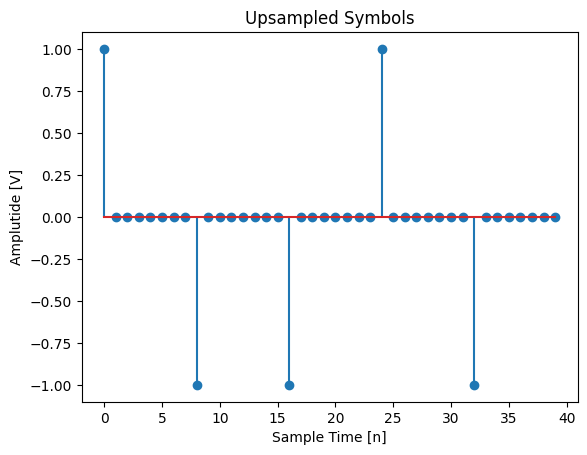

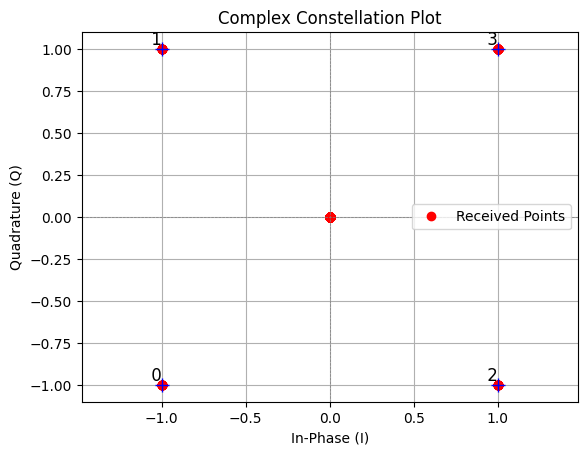

In [11]:
# plot upsampled symbols
plt.figure()
plt.stem(yk_upsampled[len(header)*fs:(len(header)+5)*fs])
plt.title("Upsampled Symbols")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

# plot upsampled constellation
sp.plot_complex_points((xk_upsampled + 1j*yk_upsampled), constellation=qpsk_constellation)

#### Pulse Shaping

Pulse shaping involves applying techniques such as windowing, sample-and-hold, or other methods to the upsampled signal to modify the waveform's envelope. This process is crucial in controlling the signal's bandwidth and mitigating unwanted spectral components. One of the primary goals of pulse shaping is to minimize intersymbol interference (ISI), which occurs when signals from adjacent symbols overlap, leading to distortion and potential errors in decoding.

In digital communication systems, the square root raised cosine (SRRC) filter is commonly employed for pulse shaping due to its effectiveness in reducing ISI while maintaining a compact signal spectrum. The SRRC pulse is characterized by its impulse response, roll-off factor $ \alpha $, and $length$. The roll-off factor $ \alpha $ controls the excess bandwidth beyond the Nyquist bandwidth, with a lower $ \alpha $ resulting in a narrower bandwidth and a sharper transition between symbols. The SRRC pulse shape filter is mathmatically represented below.

$$
p\left(nT_s\right)=\frac{1}{\sqrt{N}}\cdot \frac{sin\left(\frac{\pi \left(1-\alpha \right)n}{N}\right)+\frac{4\alpha n}{N}cos\left(\frac{\pi \left(1+\alpha \right)n}{N}\right)}{\frac{\pi n}{N}\cdot \left[1-\left(\frac{4\alpha n}{N}\right)^2\right]}
$$

where: 
- $ N $ is the upsample rate,
- $ T_s $ is the sample duration, 
- $ n $ is the sample index,
- $ \alpha $ is the roll-off factor (0 ≤ $ \alpha $ ≤ 1).

The SRRC parameters are defined below and then the resulting filter plotted to visualize the effect of different filter lengths and roll-off factors.

In [14]:
length = 64
alpha = 0.10
pulse_shape = sp.srrc(alpha, fs, length)


Filter Length: 64 samples
Message Length: 0.1 percent
Sample Rate: 8 samples per symbol



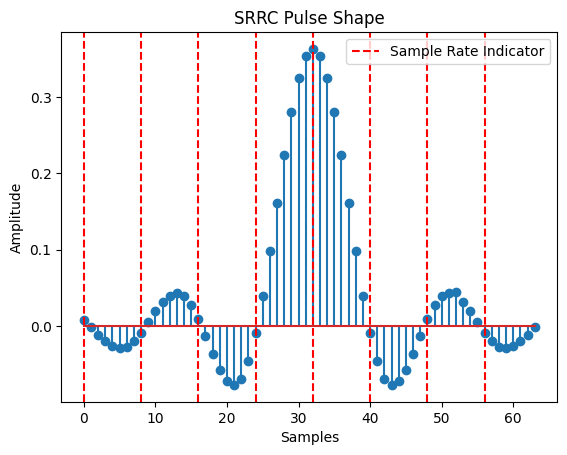

In [17]:
print(f"\nFilter Length: {length} samples")
print(f"Message Length: {alpha} percent")
print(f"Sample Rate: {fs} samples per symbol\n")

plt.figure()
plt.stem(pulse_shape)

# adding indications of sample rate multiples
for i in range(0, length, fs):
    plt.axvline(x=i, color='red', linestyle='--', label='Sample Rate Indicator' if i == 0 else "")

plt.title("SRRC Pulse Shape")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

The defined SRRC pulse shape is then applied to the upsampled message signal as well as a excerpt plotted.

In [28]:
xk_pulse_shaped = np.real(sp.convolve(xk_upsampled, pulse_shape, mode="same")[1:])
yk_pulse_shaped = np.real(sp.convolve(yk_upsampled, pulse_shape, mode="same")[1:])

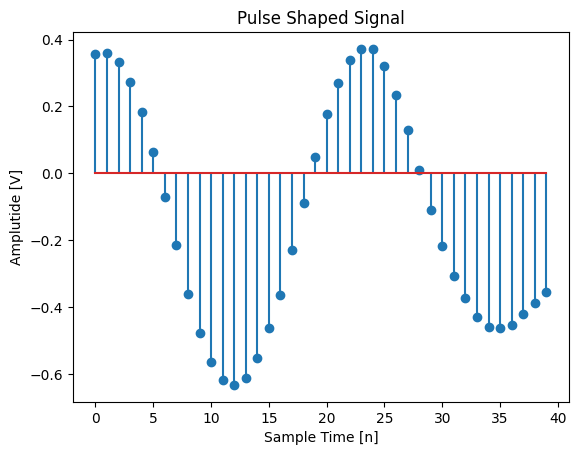

In [29]:
# plot pulse shaped signal
plt.figure()
plt.stem(yk_pulse_shaped[len(header)*fs:(len(header)+5)*fs])
plt.title("Pulse Shaped Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

#### Digital Modulation

Digital modulation encompasses the process of mixing the upsampled and now pulse shaped signal with a carrier, usually at some predefined radio frequency (RF). This is performed below via multiplication with a complex exponential representing two orthogonal sinusoids, one for the in-phase channel and one for the quadrature. The resulting RF signal is mathmatically defined below.

$$
s_{RF}\left(nT_s\right) = Re\left\{x\left(nT_s\right) \cdot e^{j\theta}\right\} + Im\left\{y\left(nT_s\right) \cdot e^{j\theta}\right\}
$$

$$
\theta = 2\pi \:\frac{f_c}{f_s}\:nT_s + \phi_c
$$

where:
- $f_c$ is the previously defined carrier frequency,
- $f_s$ is the system sample rate,
- $\phi_c$ represents the carrier phase offset,
- the factor $\sqrt{2}$ is applied in both the modulator and demodulator to offset the $\frac{1}{2}$ terms that result from the trigonometric double-angle identities used in the process.

In [30]:
s_rf = (
    np.sqrt(2) * np.real(sp.modulate_by_exponential(xk_pulse_shaped, fc, fs, phase=0, noise=noise)) +
    np.sqrt(2) * np.imag(sp.modulate_by_exponential(yk_pulse_shaped, fc, fs, phase=0, noise=noise))
)

An excerpt is plotted below to visualize the result of the digital modulation process.

Oscillator Frequency: 2.0 Hz


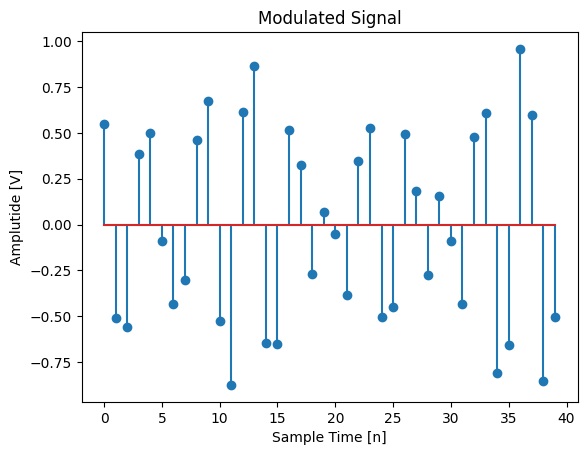

In [31]:
print(f"Oscillator Frequency: {fc} Hz")

# plot modulated RF signal
plt.figure()
plt.stem(s_RF[len(header)*fs:(len(header)+5)*fs])
plt.title("Modulated Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

In practical systems, a Digital-to-Analog Converter (DAC) follows this step to enable over-the-air transmission, utilizing its own distinct sampling and mixing parameters. At the receiver, a corresponding Analog-to-Digital Converter (ADC) would ideally be synchronized with the transmitter in terms of sample rates and mixing parameters. For simplicity, these components are omitted in this example but will be reintroduced in future examples.

<div style="text-align: center;">
    <img src="./images/QPSK/qpsk_adc_dac_diagram.png" alt="" width="750" />
    <p style="text-align: center;">Figure 2: DAC and ADC Sampling Effects</p>
</div>


&nbsp;
### Receiver Architecture

#### Digital Demodulation

Similar to the modulation peformed at the transmitter, the receiver uses the same architecture to demodulated the RF signal. This process is mathmatically defined below using the multiplication of a complex exponential where $\theta$ is defined the same as in the transmitter.

$$
Re\left\{s_{RF}\left(nT\right)\cdot \:\:exp\left(j\theta \right)\right\}\:=\:s_{real}\left(nT\right)+s_{real}\left(nT\right)cos\left(2\theta \right)+s_{real}\left(nT\right)sin\left(2\theta \right)
$$

$$
Im\left\{s_{RF}\left(nT\right)\cdot \:\:exp\left(j\theta \right)\right\}\:=\:s_{imag}\left(nT\right)-s_{imag}\left(nT\right)cos\left(2\theta \right)+s_{imag}\left(nT\right)sin\left(2\theta \right)
$$

$$
\theta = 2\pi \:\frac{f_c}{f_s}\:nT_s + \phi_c
$$

In both cases match filtering removes the double frequency terms leaving the baseband signal.

In [5]:
xr_nT = np.sqrt(2) * np.real(sp.modulate_by_exponential(s_rf, fc, fs, phase=0, noise=noise))
yr_nT = np.sqrt(2) * np.imag(sp.modulate_by_exponential(s_rf, fc, fs, phase=0, noise=noise))

NameError: name 's_rf' is not defined

An excerpt is plotted below to visualize the result of the digital demodulation process.

Oscillator Frequency: 2.0 Hz


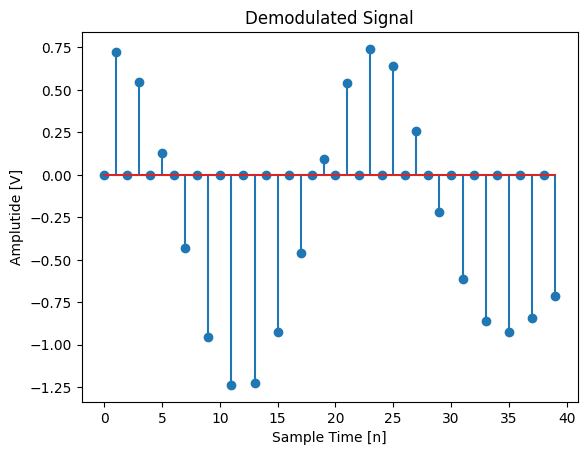

In [33]:
print(f"Oscillator Frequency: {fc} Hz")

# plot demodulated signal
plt.figure()
plt.stem(yr_nT[len(header)*fs:(len(header)+5)*fs])
plt.title("Demodulated Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

#### Match Filtering

Matched filtering is a pulse compression technique employed to maximize the signal-to-noise ratio (SNR) of the received signal, enhancing the detection of the transmitted symbols in the presence of noise. This technique involves filtering the received signal with the time-reversed and complex conjugate of the pulse shape used during transmission. For this example, the matched filter corresponds to the previously defined square root raised cosine (SRRC) filter.

The primary advantage of matched filtering is that it optimizes the SNR at the sampling instants, which is critical for accurate symbol detection. By correlating the received signal with the expected pulse shape, the matched filter effectively compresses the energy of each symbol into a narrow peak at the symbol timing, while simultaneously minimizing the impact of noise and intersymbol interference (ISI) from adjacent symbols. This process is represented mathmatically below.

$$
\:x_{mf}\left(nT\right)=conv\left(s_{real}\left(nT\right),\:\:p^{\ast \:}\left(-nT\right)\right)
$$

$$
\:y_{mf}\left(nT\right)=conv\left(s_{imag}\left(nT\right),\:\:p^{\ast \:}\left(-nT\right)\right)
$$

In [35]:
xr_nT_match_filtered = np.real(sp.convolve(xr_nT, pulse_shape, mode="same")[1:])
yr_nT_match_filtered = np.real(sp.convolve(yr_nT, pulse_shape, mode="same")[1:])

An excerpt from the mmatch filtered signal is plotted below for visualization.

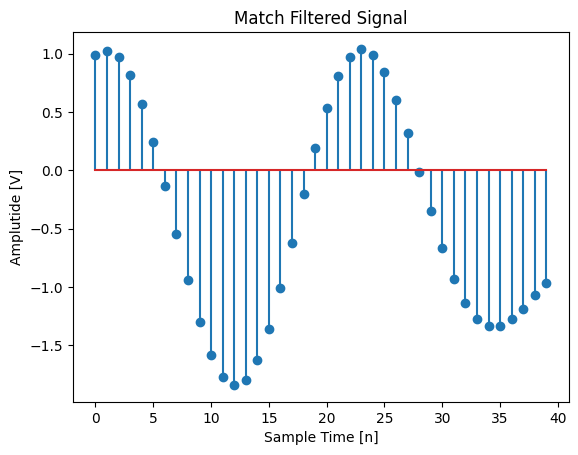

In [37]:
# plot match filtered signal
plt.figure()
plt.stem(yr_nT_match_filtered[len(header)*fs:(len(header)+5)*fs])
plt.title("Match Filtered Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

#### Downsampling

Since the developed system is fully synchronized, with no frequency, phase, or timing offsets introduced, direct downsampling can be employed to select the desired sample points. Downsampling reduces the sampling rate by selecting a subset of samples from the upsampled signal, effectively converting the high-rate signal back to a lower rate that matches the symbol rate of the original data. This process is mathmatically defined below

$$
x\left(nT_s\right)\:\rightarrow \:x_{downsampled}\left(nT_s\cdot N\right)
$$

where:
- $N $ is the down sample rate which matches the selected upsample rate used during transmission.

In [38]:
xk = sp.downsample(xr_nT_match_filtered, fs)
yk= sp.downsample(yr_nT_match_filtered, fs)

# combinding inphase and quadrature signal components
rk = xk + 1j * yk

The downsampled received constellation points are plotted below.

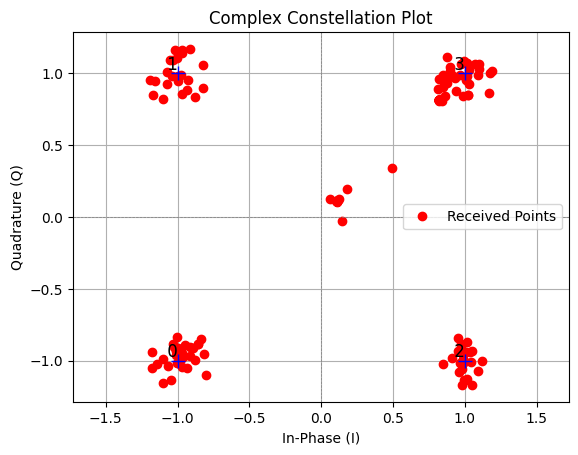

In [40]:
sp.plot_complex_points(rk, constellation=qpsk_constellation)

#### Symbol Decision

With the downsampled received signal prepared, it can now be mapped back from constellation points to symbols using a nearest neighbor algorithm. This process involves comparing each received constellation point with all possible points defined by the modulation scheme—in this case, four points for QPSK—and calculating the Euclidean distance between them. The symbol corresponding to the nearest constellation point is then selected as the decoded symbol. The nearest neighbor algorithm is detailed below
$$
  \hat{s} = \arg \min_{s_i \in S} \| r - s_i \|
$$

where:
- $r$ is the received signal point in the complex plane,
- $S = \{s_1, s_2, \ldots, s_M\}$ is the set of all possible constellation points,
- $\| r - s_i \| $ represents the Euclidian distance between $r$ and $s_i$,
- $\hat{s}$ is the estimated transmitted symbol.


In [41]:
detected_symbols = sp.nearest_neighbor(rk[len(header):], qpsk_constellation)

# calculating the error (mismatch) between the transmit and receive message
error_count = sp.error_count(input_message_symbols, detected_symbols)
print(f"Transmission Symbol Errors: {error_count}")
print(f"Bit Error Percentage: {round((error_count * 2) / len(detected_symbols), 2)} %")


Transmission Symbol Errors: 1
Bit Error Percentage: 0.02 %


The estimated receive symbols can now be converted back to binary representations and then grouped into ascii characters.

In [42]:
detected_bits = []
for symbol in detected_symbols:
    detected_bits += ([*bin(symbol)[2:].zfill(2)])

message = sp.bin_to_char(detected_bits)
print("\n"+message+"\n")


this is a qpsk transceiver tes

